In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle

In [4]:
print(os.listdir("C:/UCin/Sem 3/ashrae-energy-prediction"))

['building_metadata.csv', 'sample_submission.csv', 'test.csv', 'train.csv', 'weather_test.csv', 'weather_train.csv']


In [6]:
%%time
root = 'C:/UCin/Sem 3/ashrae-energy-prediction/'
train_df = pd.read_csv(root + 'train.csv')
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')

weather_train_df = pd.read_csv(root + 'weather_train.csv')
test_df = pd.read_csv(root + 'test.csv')
weather_test_df = pd.read_csv(root + 'weather_test.csv')
building_meta_df = pd.read_csv(root + 'building_metadata.csv')
sample_submission = pd.read_csv(root + 'sample_submission.csv')

Wall time: 53.4 s


In [7]:
print('Size of train_df data', train_df.shape)
print('Size of weather_train_df data', weather_train_df.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train_df data (20216100, 4)
Size of weather_train_df data (139773, 9)
Size of weather_test_df data (277243, 9)
Size of building_meta_df data (1449, 6)


In [8]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [13]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


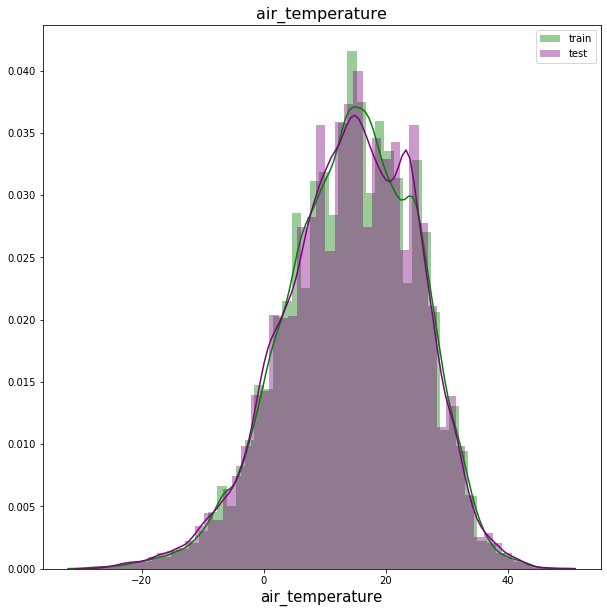

In [34]:
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train_df[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test_df[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()
    
plot_dist_col('air_temperature')


In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

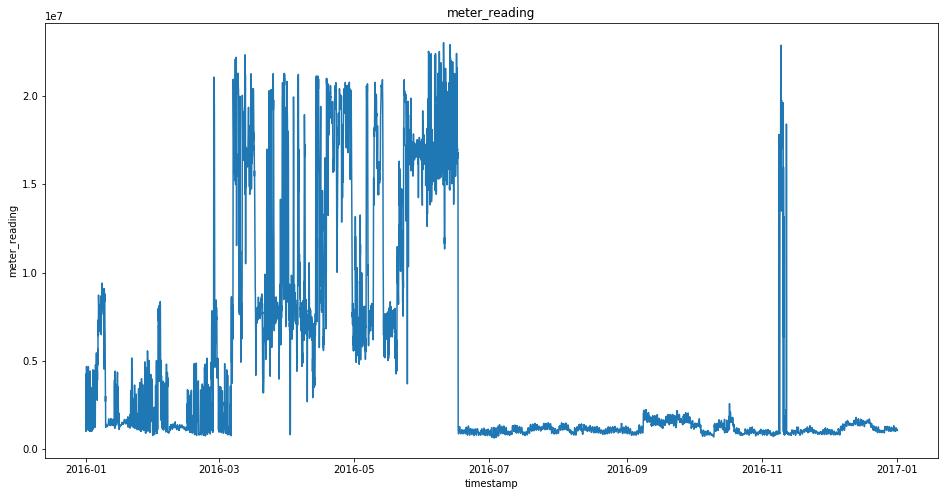

In [37]:
ts=train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts);

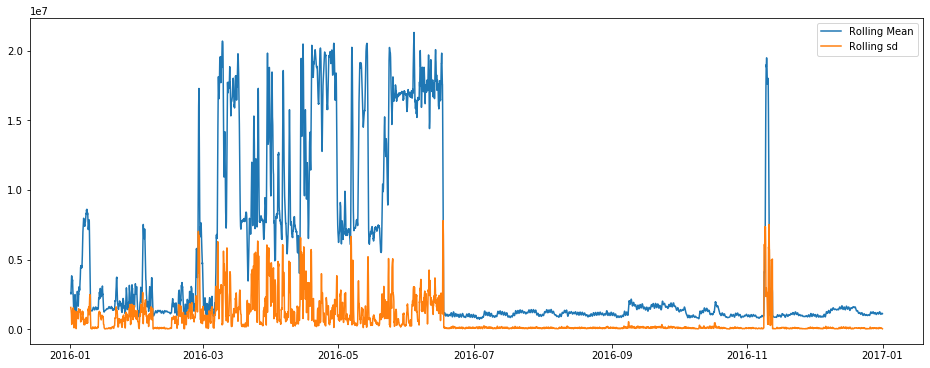

In [38]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

C:\Users\Jagruti Joshi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



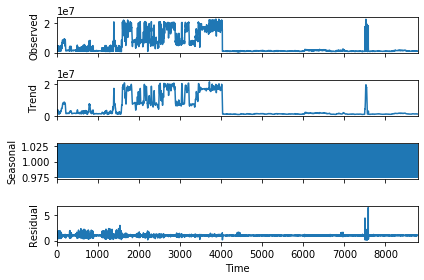

In [39]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

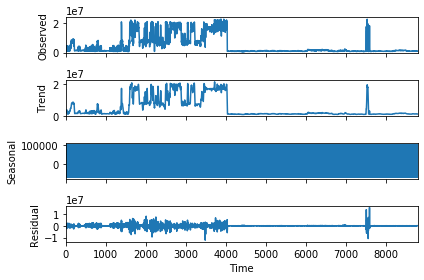

In [40]:
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
fig = res.plot()

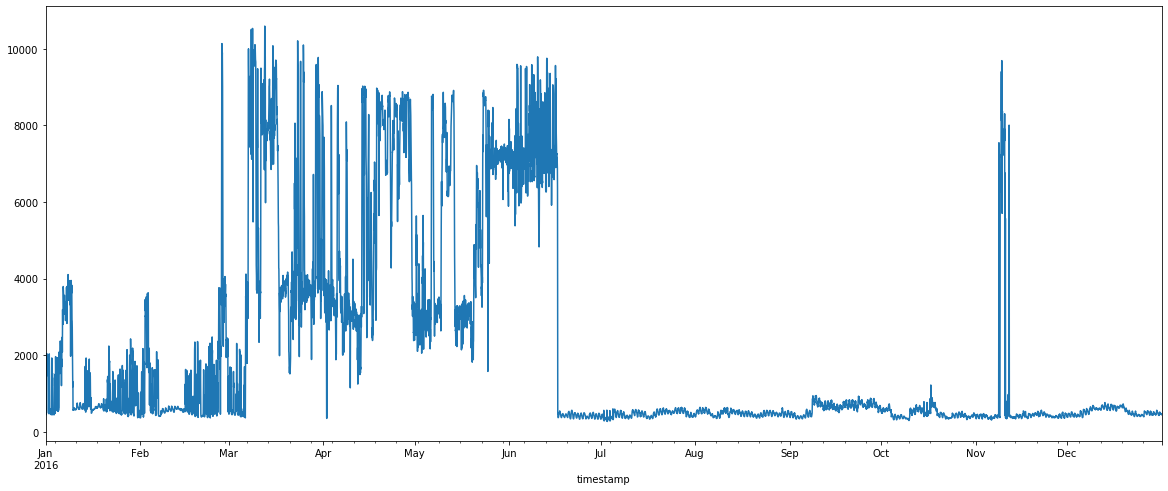

In [41]:
y_mean_time = train_df.groupby('timestamp').meter_reading.mean()
y_mean_time.plot(figsize=(20, 8))

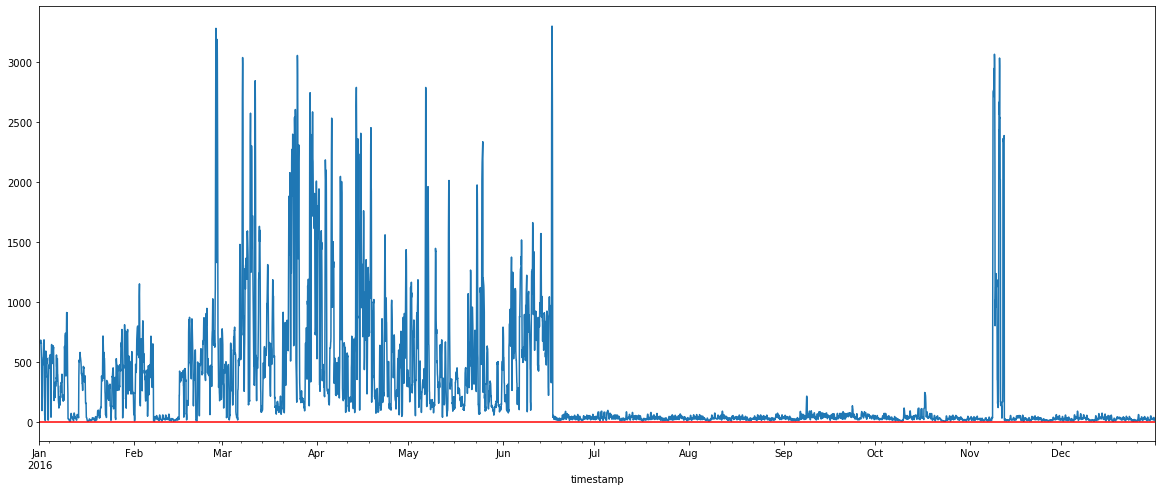

In [42]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
ax = plt.axhline(y=0.009, color='red')

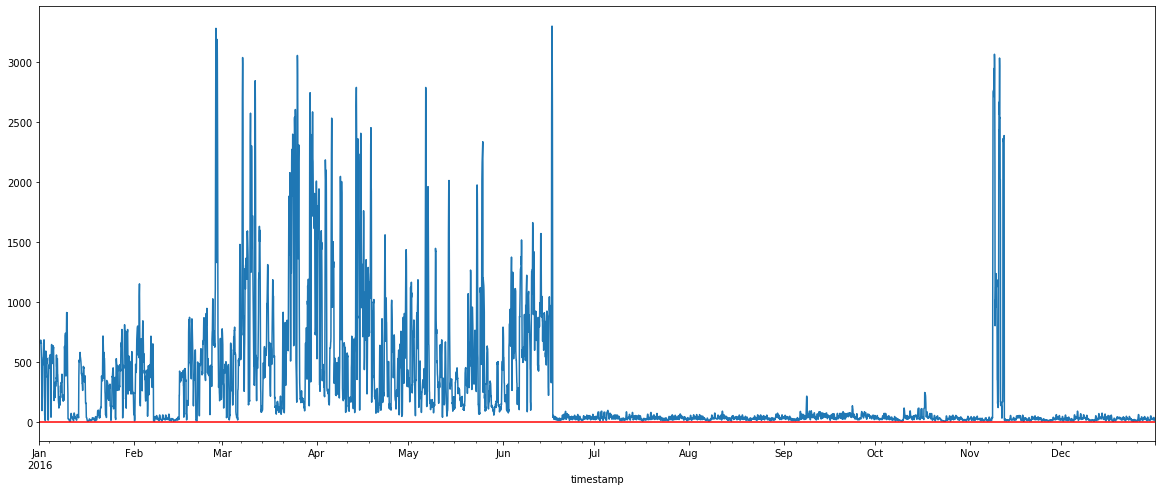

In [43]:
y_mean_time.rolling(window=10).std().plot(figsize=(20, 8))
plt.axhline(y=0.009, color='red')
plt.axvspan(0, 905, color='green', alpha=0.1)
plt.axvspan(906, 1505, color='red', alpha=0.1)

In [44]:
train_df['meter'] = pd.Categorical(train_df['meter']).rename_categories({0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'})
daily_train = train_df.copy()
daily_train['date'] = daily_train['timestamp'].dt.date
daily_train = daily_train.groupby(['date', 'building_id', 'meter']).sum()
daily_train

meter_reading
date       building_id meter                      
2016-01-01 0           electricity           0.000
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN
           1           electricity           0.000
...                                            ...
2016-12-31 1447        hotwater                NaN
           1448        electricity          79.975
                       chilledwater            NaN
                       steam                   NaN
                       hotwater                NaN

[2121336 rows x 1 columns]

In [45]:
daily_train_agg = daily_train.groupby(['date', 'meter']).agg(['sum', 'mean', 'idxmax', 'max'])
daily_train_agg = daily_train_agg.reset_index()
level_0 = daily_train_agg.columns.droplevel(0)
level_1 = daily_train_agg.columns.droplevel(1)
level_0 = ['' if x == '' else '-' + x for x in level_0]
daily_train_agg.columns = level_1 + level_0
daily_train_agg.rename_axis(None, axis=1)
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max
0,2016-01-01,electricity,4.219647e+06,3037.903035,"(2016-01-01, 803, electricity)",116037.18
1,2016-01-01,chilledwater,1.412169e+06,3090.084935,"(2016-01-01, 1289, chilledwater)",104211.65
2,2016-01-01,steam,6.873201e+07,218891.736502,"(2016-01-01, 1099, steam)",50950800.00
3,2016-01-01,hotwater,1.609989e+06,11180.481533,"(2016-01-01, 1331, hotwater)",219824.53
4,2016-01-02,electricity,4.288951e+06,3085.576378,"(2016-01-02, 803, electricity)",115776.75


In [46]:
fig_total = px.line(daily_train_agg, x='date', y='meter_reading-sum', color='meter', render_mode='svg')
fig_total.update_layout(title='Total kWh per energy aspect')
fig_total.show()

In [47]:
fig_maximum = px.line(daily_train_agg, x='date', y='meter_reading-max', color='meter', render_mode='svg')
fig_maximum.update_layout(title='Maximum kWh value per energy aspect')
fig_maximum.show()

In [48]:
daily_train_agg['building_id_max'] = [x[1] for x in daily_train_agg['meter_reading-idxmax']]
daily_train_agg.head()

,date,meter,meter_reading-sum,meter_reading-mean,meter_reading-idxmax,meter_reading-max,building_id_max
0,2016-01-01,electricity,4.219647e+06,3037.903035,"(2016-01-01, 803, electricity)",116037.18,803
1,2016-01-01,chilledwater,1.412169e+06,3090.084935,"(2016-01-01, 1289, chilledwater)",104211.65,1289
2,2016-01-01,steam,6.873201e+07,218891.736502,"(2016-01-01, 1099, steam)",50950800.00,1099
3,2016-01-01,hotwater,1.609989e+06,11180.481533,"(2016-01-01, 1331, hotwater)",219824.53,1331
4,2016-01-02,electricity,4.288951e+06,3085.576378,"(2016-01-02, 803, electricity)",115776.75,803


In [ ]:
def show_building(building, energy_aspects=None):
    fig = px.line(daily_train.loc[(slice(None), building, slice(None)), :].reset_index(),
                  x='date',
                  y='meter_reading',
                  color='meter',
                  render_mode='svg')
    if energy_aspects:
        if 'electricity' not in energy_aspects:
            fig['data'][0].visible = 'legendonly'
        if 'chilledwater' not in energy_aspects:
            fig['data'][1].visible = 'legendonly'
        if 'steam' not in energy_aspects:
            fig['data'][2].visible = 'legendonly'
        if 'hotwater' not in energy_aspects:
            fig['data'][3].visible = 'legendonly'
    fig.update_layout(title='Building ID: {}'.format(building))        
    fig.show()
    display(building_metadata[building_metadata['building_id']==building])

In [49]:
print('Number of days that a building has the maximum electricity consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'electricity']['building_id_max'].value_counts())

Number of days that a building has the maximum electricity consumption of all the buildings:

803     192
801      65
799      58
1088     49
993       1
794       1
Name: building_id_max, dtype: int64


In [50]:
daily_train_electricity = daily_train_agg[daily_train_agg['meter']=='electricity'].copy()
daily_train_electricity['building_id_max'] = pd.Categorical(daily_train_electricity['building_id_max'])
fig_daily_electricity = px.scatter(daily_train_electricity,
                                   x='date',
                                   y='meter_reading-max',
                                   color='building_id_max',
                                   render_mode='svg')
fig_daily_electricity.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_electricity.show()

In [51]:
print('Number of days that a building has the maximum chilledwater consumption of all the buildings:\n')
print(daily_train_agg[daily_train_agg['meter'] == 'chilledwater']['building_id_max'].value_counts())

Number of days that a building has the maximum chilledwater consumption of all the buildings:

1284    134
76       92
1258     41
1289     38
778      37
1088     10
29       10
1156      2
60        1
50        1
Name: building_id_max, dtype: int64


In [52]:
daily_train_chilledwater = daily_train_agg[daily_train_agg['meter']=='chilledwater'].copy()
daily_train_chilledwater['building_id_max'] = pd.Categorical(daily_train_chilledwater['building_id_max'])
fig_daily_chilledwater = px.scatter(daily_train_chilledwater,
                                    x='date',
                                    y='meter_reading-max',  
                                    color='building_id_max', 
                                    render_mode='svg')
fig_daily_chilledwater.update_layout(title='Maximum consumption values for the day and energy aspect')
fig_daily_chilledwater.show()